In [1]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation, Input
from tensorflow.keras.initializers import GlorotUniform
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
from sklearn.metrics import r2_score

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import time

# Set data type
#DTYPE='float32'
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)
print('TensorFlow version used: {}'.format(tf.__version__))




TensorFlow version used: 2.15.0


In [2]:
# Final time
T = tf.constant(1., dtype=DTYPE)

# Spatial dimensions
dim = 100

# Domain-of-interest at t=0
a = 90 * tf.ones((dim), dtype=DTYPE)
b = 110 * tf.ones((dim), dtype=DTYPE)

# Interest rate
r = tf.constant(1./20, dtype=DTYPE)

# Drift
mu = tf.constant(-1./20, dtype=DTYPE)

# Strike price
K = tf.constant(100., dtype=DTYPE)

# Diffusion/volatility
beta_i = 1./10 + 1./200*tf.range(1, dim+1, dtype=DTYPE)

# Define terminal condition, i.e., payoff at maturity
# Define the payoff function phi
def phi(x):
    return tf.exp(-mu * T) * tf.maximum(110 - tf.reduce_min(x, axis=1, keepdims=True), 0)

In [3]:
# Define a correlation matrix Q
Q = np.ones([dim, dim]) * 0.5
np.fill_diagonal(Q, 1.)

# Perform Cholesky decomposition on Q to get sigma (volatility) and sigma_norms
L = np.linalg.cholesky(Q)
sigma_norms = tf.constant(np.linalg.norm(L, axis=0), dtype=DTYPE)
sigma = tf.constant(L, dtype=DTYPE)

In [4]:
def calculate_H(num_samples, a, b):
    """ Function to calculate H for num_samples many pairs of uniformly drawn starting
    values X_0 and end points X_T of a stochastic process X with zero drift and
    constant scalar diffusion. Starting points are drawn uniformly from the
    hypercube [a,b] \\subset \mathbb{R}^d. """
    # Create a 100x100 ma
    # trix with diagonal elements of 1 and off-diagonal elements of 1/2
 
    dim = a.shape[0]
    X0 = a + tf.random.uniform((num_samples, dim), dtype=DTYPE) * (b - a)
    Xi = tf.random.normal(shape=(num_samples, dim), dtype=DTYPE)
    XT = X0 * tf.exp((mu - 1/2 * (beta_i * sigma_norms) ** 2) * T +  tf.matmul(tf.sqrt(T)* Xi, sigma))
    
    # Stack the list of XT values along a new dimension to create the final output
    
    return tf.stack([X0, XT],2)


In [5]:
n_test1 = 200000
X1 = calculate_H(n_test1, a, b)
Xtest1 = X1[:, :, 0]
Xtest1 = tf.convert_to_tensor(Xtest1, dtype=DTYPE)
Y = tf.zeros((Xtest1.shape[0], 1), dtype=DTYPE)  # Create an initial Ytest tensor filled with zeros
b_size = 32
mc_samples1 = 4000

def mc_samples2(y):
    Xi = tf.random.normal(shape=(b_size, dim), dtype=DTYPE)
    upd = tf.exp((mu - 1/2 * (beta_i * sigma_norms) ** 2) * T +  tf.matmul(tf.sqrt(T)* Xi, sigma))
    XT = tf.reshape(Xtest1, shape=[n_test1, dim, 1]) * tf.transpose(upd)
    expected_payoff = tf.reduce_sum(tf.reshape(phi(XT), [n_test1, b_size]), axis=1, keepdims=True)
    return y + expected_payoff / (b_size * mc_samples1)

for i in range(mc_samples1):
    Y = mc_samples2(Y)


In [6]:
def init_model(dim, activation='tanh',
               num_hidden_neurons=200,
               num_hidden_layers=3,
               initializer=GlorotUniform()):
    model = Sequential()
    model.add(Input(shape=(dim,)))
    model.add(BatchNormalization(epsilon=1e-6))

    # Create a fixed number of hidden layers
    for _ in range(num_hidden_layers):
        model.add(Dense(num_hidden_neurons,
                        activation=None,
                        use_bias=False,
                        kernel_initializer=initializer))
        model.add(BatchNormalization(epsilon=1e-6))
        model.add(Activation(activation))

    model.add(Dense(1,
                    activation=None,
                    use_bias=False,
                    kernel_initializer=initializer))
    model.add(BatchNormalization(epsilon=1e-6))
    return model

In [7]:
# Define the model
model = init_model(dim=dim)

# Learning rate schedule and optimizer
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([750, 1500], [1e-3, 1e-4, 1e-5])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)


# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 200)               20000     
                                                                 
 batch_normalization_1 (Bat  (None, 200)               800       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               40000     
                                                                 
 batch_normalization_2 (Bat  (None, 200)               

c:\Users\yjerm\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [8]:
Y = np.array(Y)
df = pd.DataFrame(Xtest1)
df['Y'] = Y
X_train_val1, X_test1, y_train_val1, y_test1 = train_test_split(df.drop(columns=['Y']), df.loc[:, 'Y'], test_size=0.2, random_state=42)
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42)

In [9]:
from keras.callbacks import Callback
import time

class CustomCallback(Callback):
    def __init__(self):
        super().__init__()
        self.epoch_times = []
        self.train_losses = []
        self.val_losses = []
        self.predictions = []

    def on_train_begin(self, logs=None):
        self.epoch_times.clear()
        self.train_losses.clear()
        self.val_losses.clear()
        self.predictions.clear()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

        # Save the losses
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        # Save predictions for the validation data
        predictions = self.model.predict(X_val1).flatten()  # Make sure X_val1 is defined and accessible
        self.predictions.append(predictions)

# Initialize the callback
custom_callback = CustomCallback()


In [10]:
# Train the model with the custom callback
start_time = time.time()
history2 = model.fit(
    X_train_val1, 
    y_train_val1,
    batch_size=256, 
    epochs=3000, 
    validation_data=(X_val1, y_val1), 
    callbacks=[custom_callback]  # Add custom_callback here
)
end_time = time.time()
total_time = end_time - start_time

# Print the total time for model fitting
print(f"Total time for model fitting: {total_time/3600:.3f} hours")



Epoch 1/3000

625/625 [==============================] - 12s 15ms/step - loss: 503.8212 - val_loss: 0.0049
Epoch 2/3000
625/625 [==============================] - 9s 15ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 3/3000
625/625 [==============================] - 9s 14ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 4/3000
625/625 [==============================] - 9s 15ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 5/3000
625/625 [==============================] - 8s 13ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 6/3000
625/625 [==============================] - 8s 13ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 7/3000
625/625 [==============================] - 9s 14ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 8/3000
625/625 [==============================] - 8s 13ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 9/3000
625/625 [==============================] - 8s 13ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 10/3000
625/625 [==============================] - 9s 14ms/step

In [11]:
# Extract the last prediction from each epoch 
last_predictions = [epoch_predictions[-1] for epoch_predictions in custom_callback.predictions]

# Create a DataFrame with the logged data
results_df = pd.DataFrame({
    'Epoch': range(1, len(custom_callback.train_losses) + 1),
    'Training_Loss': custom_callback.train_losses,
    'Validation_Loss': custom_callback.val_losses,
    'Epoch_Run_Time(s)': custom_callback.epoch_times,
    'Last_Prediction': last_predictions
})

# Save the DataFrame to a CSV file
results_df.to_csv('model_performance_GBM_corrolated_noise.csv', index=False)

In [12]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error

# Assuming you have already trained your model and obtained predictions for both validation and test data
y_pred_val1 = model.predict(X_val1)  # Predictions for validation data
y_pred_test1 = model.predict(X_test1)  # Predictions for test data
y_pred_train1 = model.predict(X_train1)  # Predictions for training data


# Calculate R-squared for both sets
r_squared_val1 = r2_score(y_val1, y_pred_val1)
r_squared_test1 = r2_score(y_test1, y_pred_test1)
r_squared_train1 = r2_score(y_train1, y_pred_train1)

# Calculate MAE for all three datasets
mae_val1 = mean_absolute_error(y_val1, y_pred_val1)
mae_test1 = mean_absolute_error(y_test1, y_pred_test1)
mae_train1 = mean_absolute_error(y_train1, y_pred_train1)

# Calculate MSE for all three datasets
mse_val1 = mean_squared_error(y_val1, y_pred_val1)
mse_test1 = mean_squared_error(y_test1, y_pred_test1)
mse_train1 = mean_squared_error(y_train1, y_pred_train1)



print(f"Accuracy on Validation Data: {r_squared_val1 * 100}")
print(f"Accuracy on Test Data: {r_squared_test1 * 100}")
print(f"Accuracy on Train Data: {r_squared_test1 * 100}")

print(f"Mean Absolute Error (MAE) on Validation Data: {mae_val1:.4f}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae_test1:.4f}")
print(f"Mean Absolute Error (MAE) on Training Data: {mae_train1:.4f}")

print(f"Mean Squared Error (MSE) on Validation Data: {mse_val1:.4f}")
print(f"Mean Squared Error (MSE) on Test Data: {mse_test1:.4f}")
print(f"Mean Squared Error (MSE) on Training Data: {mse_train1:.4f}")


625/625 [==============================] - 3s 4ms/step
Accuracy on Validation Data: 91.93221530929165
Accuracy on Test Data: 91.98352798633165
Accuracy on Train Data: 91.98352798633165
Mean Absolute Error (MAE) on Validation Data: 0.0203
Mean Absolute Error (MAE) on Test Data: 0.0202
Mean Absolute Error (MAE) on Training Data: 0.0202
Mean Squared Error (MSE) on Validation Data: 0.0007
Mean Squared Error (MSE) on Test Data: 0.0007
Mean Squared Error (MSE) on Training Data: 0.0007


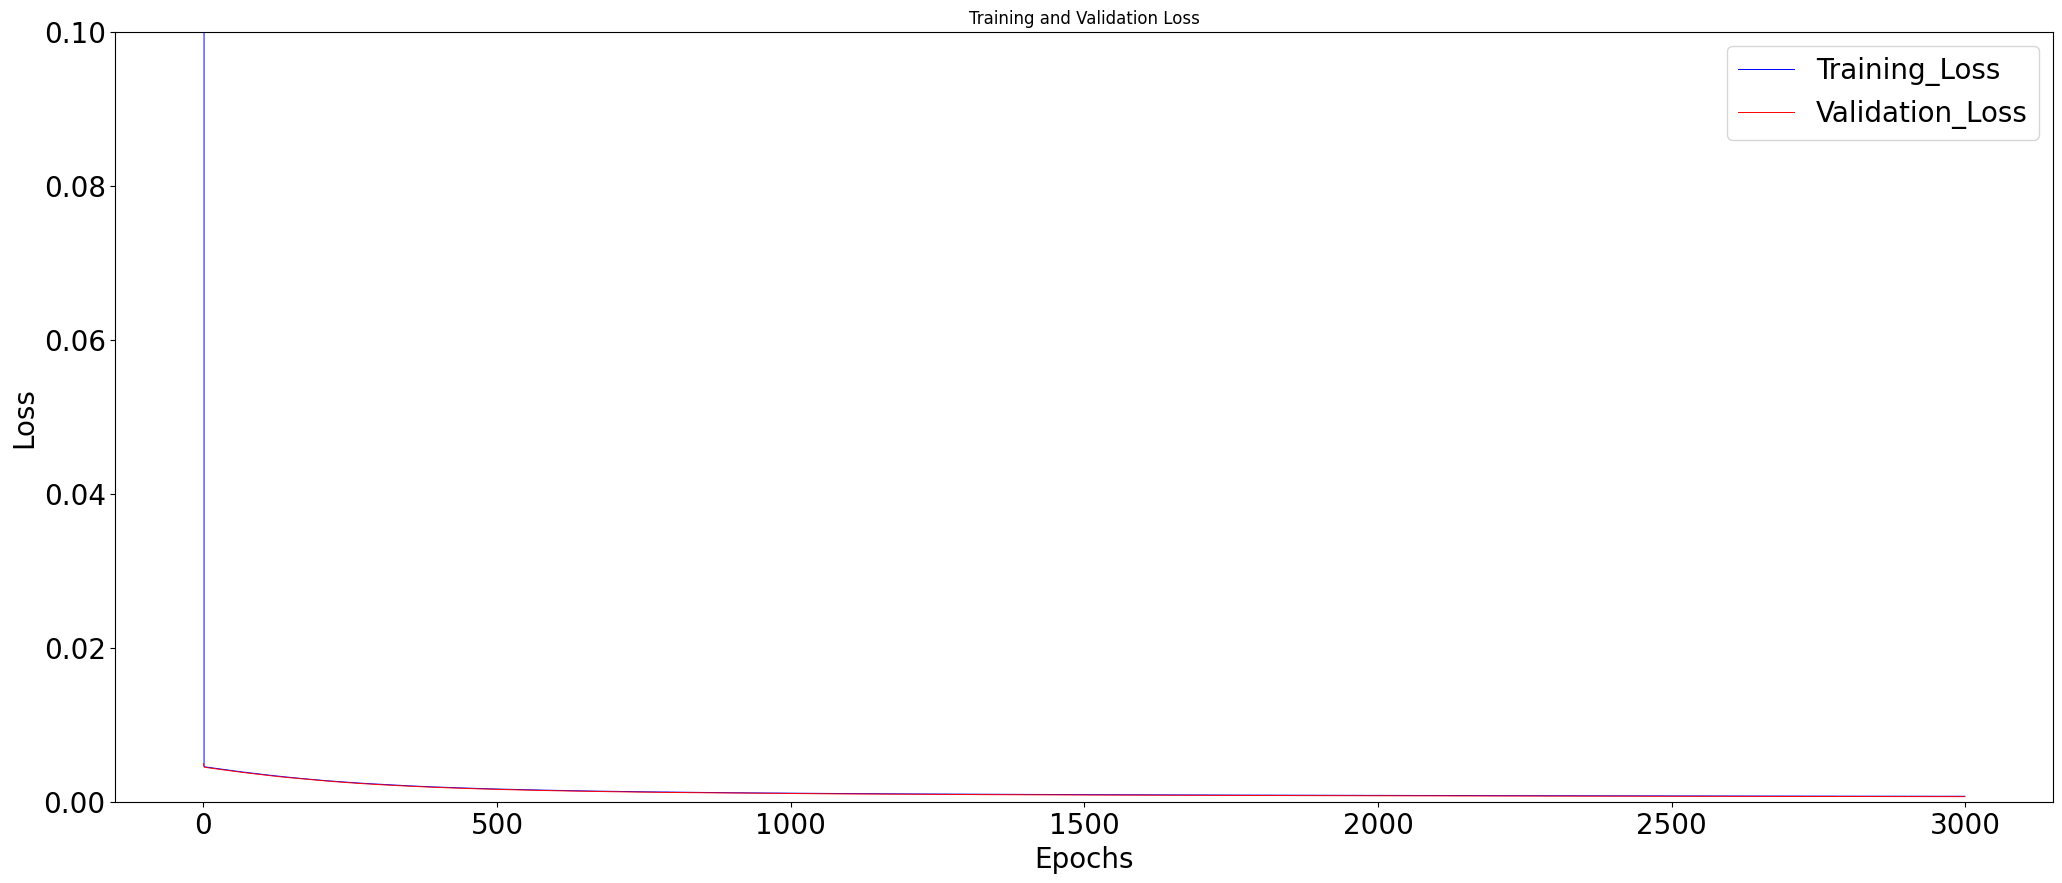

In [70]:
performance = pd.read_csv("model_performance_GBM_corrolated_noise.csv")
# Create a subplot grid with two subplots side by side
plt.figure(figsize=(25, 10))

# Plot the blue line for "Approximation" and the horizontal line for "Exact Solution" on the first subplot
plt.plot(performance['Training_Loss'], color = 'b',label="Training_Loss", linewidth=0.7)
plt.plot(performance['Validation_Loss'], color = 'r',label="Validation_Loss", linewidth=0.7)

plt.xlabel('Epochs',fontsize="20")
plt.ylabel('Loss',fontsize="20")
plt.title('Training and Validation Loss')
plt.xticks(size = 20)
plt.yticks(size = 20)


# Customize the plot style
# plt.style.use("seaborn")
plt.ylim(0,0.1)
# plt.savefig("training_loss_plot_multi assets.jpg", format="jpeg", dpi = 500)
plt.legend(fontsize="20")
# Show the combined plot
plt.show()

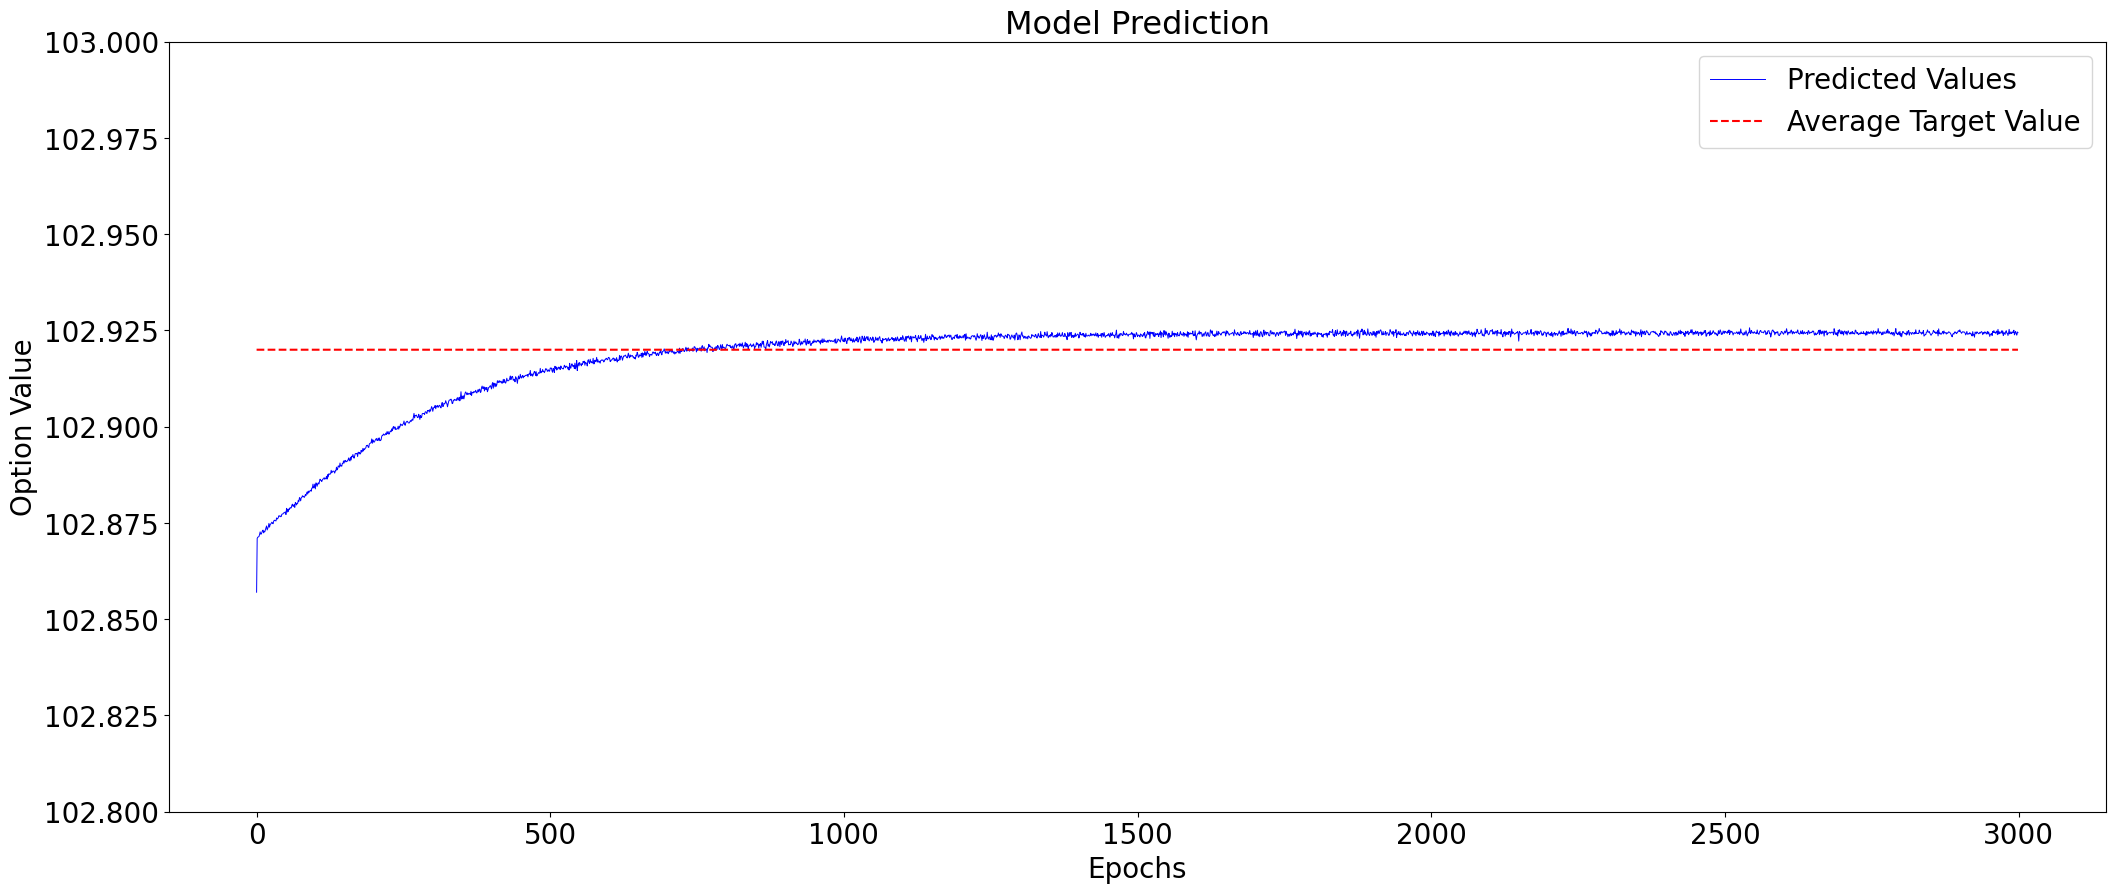

In [83]:
plt.figure(figsize=(25, 10))
plt.plot(performance['Last_Prediction'], color = 'b',label="Predicted Values", linewidth=0.7)
# Create an array of the same length as the number of epochs for plotting the average target value
average_target_value_line = np.full_like(performance['Last_Prediction'], 102.92)
plt.plot(average_target_value_line, linestyle='--', color='red', label='Average Target Value')
plt.ylim(102.8,103)
plt.xlabel('Epochs',fontsize="20")
plt.ylabel('Option Value',fontsize="20")
plt.title('Model Prediction',fontsize="23")
plt.xticks(size = 20)
plt.yticks(size = 20)


# Customize the plot style
# plt.style.use("seaborn")
plt.legend(fontsize="20")
# plt.savefig("solution GBM.jpg", format="jpeg", dpi = 500)
# Show the combined plot
plt.show()